# *Лабораторная работа №4*

Рассмотрим набор данных IMDB, содержащий 50 000 обзоров фильмов с точки зрения обработки естественного языка.

Этот набор данных для бинарной классификации эмоциональной окраски. Набор состоит из 25 000 высокорелевантных обзоров фильмов для обучения и 25 000 для тестирования.

Подключим большую часть необходимых библиотек.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
import tensorflow as tf

Загрузим набор данных.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/7sokxhbwg2kz33k/IMDB%20Dataset.csv

Считаем загруженный набор данных в dataframe для дальнейшей обработки.

In [ ]:
df = pd.read_csv("IMDB Dataset.csv")
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Проверим основную информацию о представленном наборе данных.

In [ ]:
df.shape

(50000, 2)

In [ ]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Переведем текстовую оценку эмоциональной окраски отзыва в целочисленный вид.

In [ ]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df.sentiment.unique()

array([1, 0])

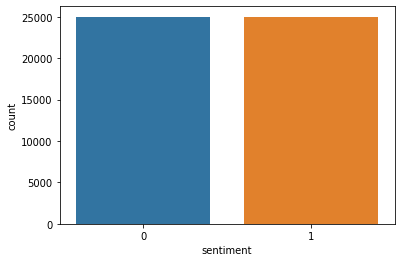

In [ ]:
sns.countplot(df["sentiment"])

In [ ]:
df["sentiment"].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

Необходимо очистить наш набор данных от зашумляющей информации и привести весь текст к нижнему регистру.

In [ ]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"http", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"@", "at")
    df[content_field] = df[content_field].str.lower()
    return df

In [ ]:
standardize_text(df,"review")

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there's a family where a little boy ...,0
4,"petter mattei's ""love in the time of money"" is...",1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,"bad plot, bad dialogue, bad acting, idiotic di...",0
49997,i am a catholic taught in parochial elementary...,0
49998,i'm going to have to disagree with the previou...,0


Подключим несколько библиотек для обработки естественного языка.

In [ ]:
import re
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Операции лемматизации, очистки от стоп-слов и иже с ними занимают очень много времени, так что после запуска следующего кода у Вас будет минимум минут 20 свободного времени.

In [ ]:
lemmatizer=WordNetLemmatizer()
corpus = []
for i in range(0,len(df)):
    review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
    review = review.split()
    review=[word for word in review if not word in set(stopwords.words('english'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review=' '.join(review)
    corpus.append(review)

Проведем векторизацию нашего текста с помощью TF-IDF.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1, 3))
X = tfidf.fit_transform(corpus)
y = df["sentiment"]

Разобьем набор данных на тренировочную и тестовую выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Воспользуемся моделью опорных векторов для проведения классификации.

In [ ]:
from sklearn.svm import LinearSVC
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
y_pred = classifier.predict(X_test)
y_pred[:5]

array([1, 0, 1, 1, 1])

Выведем результаты работы нашего классификатора в виде матрицы неточностей и метрики точности.

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      4953
           1       0.91      0.89      0.90      5047

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Accuracy Score of SVC: 90.02 %


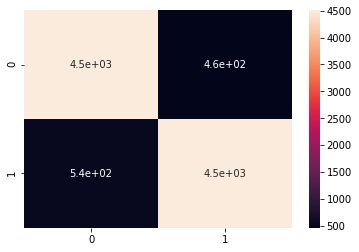

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
acc = accuracy_score(y_pred, y_test)
report = classification_report(y_pred, y_test)
cm = confusion_matrix(y_pred,y_test)
sns.heatmap(cm, annot=True)
print(report)
print("Accuracy Score of SVC:", acc*100,"%")

## Предсказание эмоциональной окраски отзыва на основе анализа естественного языка (Практическая часть)

Вам для обработки предлагается коллекция рецензий пользователей на фильмы с сайта kinopoisk.ru

Положительных: 87101

Отрицательных: 19804

Нейтральных: 24678


Все: 131583

Каждая рецензия в отдельном файле, первая часть названия файла соответствует ID фильма на kinopoisk.ru вторая часть номеру рецензии на этот фильм. Например, имя файла 306-15.txt обозначает идентификатор фильма на сайте 306, номер рецензии 15.

https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews

Произведем загрузку набора данных.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/myqjozyhxiionc3/dataset.zip

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from zipfile import ZipFile
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Распакуем все файлы в рабочую директорию.

In [ ]:
zip = ZipFile('dataset.zip')
zip.extractall()

Для облегчения дальнейшей работы код для размещения информации в dataframe уже написан.

In [ ]:
import os
import pandas as pd

df = pd.DataFrame(columns=['review','sentiment'])

path = '/content/dataset/'

for directory in os.listdir(path):
  print(directory)
  if os.path.isdir(path + directory):
    count = 0
    for filename in os.listdir(path + directory):
      with open(os.path.join(path + directory + '/', filename)) as f:
        review = f.read()
        current_df = pd.DataFrame({'review': [review], 'sentiment': directory})
        df = pd.concat([df, current_df], ignore_index=True, axis=0)
        count +=1
        if count > 20000:
          break

pos
neu
neg


Выведем несколько строк из полученного набора данных.

In [ ]:
df.sample(10)

,review,sentiment
11303,"В последнее время режиссёры, будто бы сговорив...",pos
14080,"Назвать фильм тяжелым не поворачивается язык, ...",pos
26420,Очередную экранизацию творения Стефани Майер я...,neu
35733,Кремлёвская диета\n\nНикому не убежать от прав...,neu
44512,Кинематограф - одно из величайших открытий чел...,neg
37697,"Ну что, посмотрел я это дело, найдя в хорошем ...",neu
26062,« - Телефон не работает\n - Все спутники взорв...,neu
53236,"Говоря по правде я очень удивилась, не найдя з...",neg
47129,"Мда, думала, посмотрю наконец-то неплохую росс...",neg
7705,"Стоит начать, пожалуй, с минусов, чтобы получи...",pos


Проблемой является тот момент, что все отзывы расположены подряд идущими блоками с одинаковой эмоциональной окраской. Перемешаем данные.

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

Проверим, привели ли наши действия к желаемому результату.

In [ ]:
df.head(10)

,review,sentiment
0,Великолепный фильм. Сочетание замечательных ак...,pos
1,В основу фильма положена повесть питерского пи...,neu
2,Незадолго до премьеры картину и режиссера стал...,neg
3,"Этот фильм, вопреки жанру 0+, снимался явно не...",neg
4,Этот фильм просто великолепен! Я получила огро...,pos
5,"Джон МакКлейн на этот раз, прибывает в Москву,...",neg
6,Вторую часть искромётной лирической комедии от...,pos
7,"О фильме 12 Обезьян я как-то случайно узнал, о...",pos
8,За последние годы хоррор индустрия радует появ...,neu
9,Чарльз Чаплин для меня всегда был «немым комик...,pos


Вашим заданием в данной лабораторной будет построение модели анализа естественного языка для определения эмоциональной окраски отзыва.

*Примечание*: размер датасета не позволяет обрабатывать его полностью силами бесплатного аккаунта Colab. Для того, чтобы избежать аварийного завершения работы блокнота из-за дефицита оперативной памяти, рекомендуется проводить обучение в несколько этапов с промежуточным сохранением модели.

Методика оценки - accuracy_score (В обучении и тестировании должно участвовать не менее 60000 записей, их распределение по классам должно стремиться к равномерному, т.е. 20к-20к-20к)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59829 entries, 0 to 59828
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     59829 non-null  object
 1   sentiment  59829 non-null  object
dtypes: object(2)
memory usage: 935.0+ KB


Посмотрим на распределение классов. Видно что нейртральных отзывов в 2 раза больше чем остальных вместе взятых.

<Axes: xlabel='count', ylabel='sentiment'>

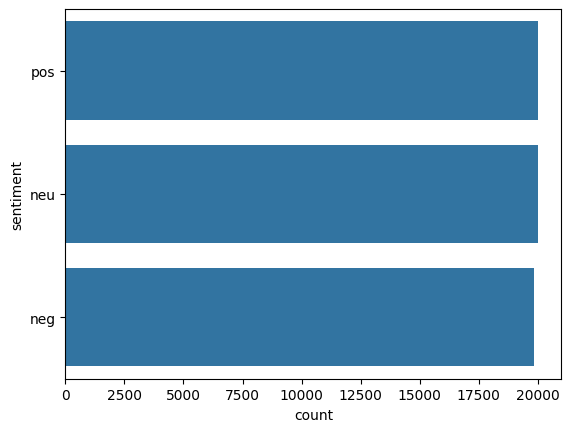

In [ ]:
sns.countplot(df['sentiment'])

Переведем текстовую оценку эмоциональной окраски отзыва в целочисленный вид.

In [ ]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

le.classes_

array(['neg', 'neu', 'pos'], dtype=object)

Очистим наш датасет от зашумляющей информации и приведем все к нижнему регистру.

In [ ]:
def standardize_text(df, content_field):
    df[content_field] = df[content_field].str.replace(r"http\S+", "")
    df[content_field] = df[content_field].str.replace(r"@\S+", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яA-Za-z0-9Ёё(),!?@\'\`\"\_\n]", " ")
    df[content_field] = df[content_field].str.replace(r"[Ёё]", "е")
    df[content_field] = df[content_field].str.replace(r"[\t\n]", "")
    df[content_field] = df[content_field].str.replace(r"[^А-Яа-яa-zA-Z]", " ")
    df[content_field] = df[content_field].str.lower()
    return df

In [ ]:
standardize_text(df, "review")

,review,sentiment
0,великолепный фильм. сочетание замечательных ак...,2
1,в основу фильма положена повесть питерского пи...,1
2,незадолго до премьеры картину и режиссера стал...,0
3,"этот фильм, вопреки жанру 0+, снимался явно не...",0
4,этот фильм просто великолепен! я получила огро...,2
...,...,...
59824,я смотрел эту часть сразу после 2й и 3й и я от...,0
59825,просто не переношу эллен пейдж! не переношу ее...,2
59826,"это не булгаков. это басов. \n\nталантливо, ин...",0
59827,правила игры «волк_одиночка»: участники садятс...,1


In [ ]:
lemmatizer=WordNetLemmatizer()
corpus = []
for i in range(0,len(df)):
    review = re.sub('[^а-яА-Я]', ' ', df['review'][i])
    review = review.split()
    review=[word for word in review if not word in set(stopwords.words('russian'))]
    review = [lemmatizer.lemmatize(word) for word in review]
    review=' '.join(review)
    corpus.append(review)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(corpus)

In [ ]:
X.shape

(59829, 8399168)

In [ ]:
y = df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
classifier = LinearSVC()
classifier.fit(X_train, y_train)

LinearSVC()

In [ ]:
y_pred = classifier.predict(X_test)

In [ ]:
acc = accuracy_score(y_test, y_pred)
acc

0.6697309042286478

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3926
           1       0.58      0.46      0.51      4011
           2       0.69      0.77      0.73      4029

    accuracy                           0.67     11966
   macro avg       0.66      0.67      0.66     11966
weighted avg       0.66      0.67      0.66     11966

